In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
tickers = ['xle', 'xlu', 'xlb', 'xlk', 'xli', 'xlv', 'xlf', 'xlp', 'xly']

In [3]:
price_dataframe = yf.download(tickers, period='max')['Close']

preprocessed_dataframe = price_dataframe.fillna(method='ffill')
preprocessed_dataframe = preprocessed_dataframe.dropna()

[*********************100%***********************]  9 of 9 completed


In [4]:
normalizedDataframe = preprocessed_dataframe.pct_change().dropna()

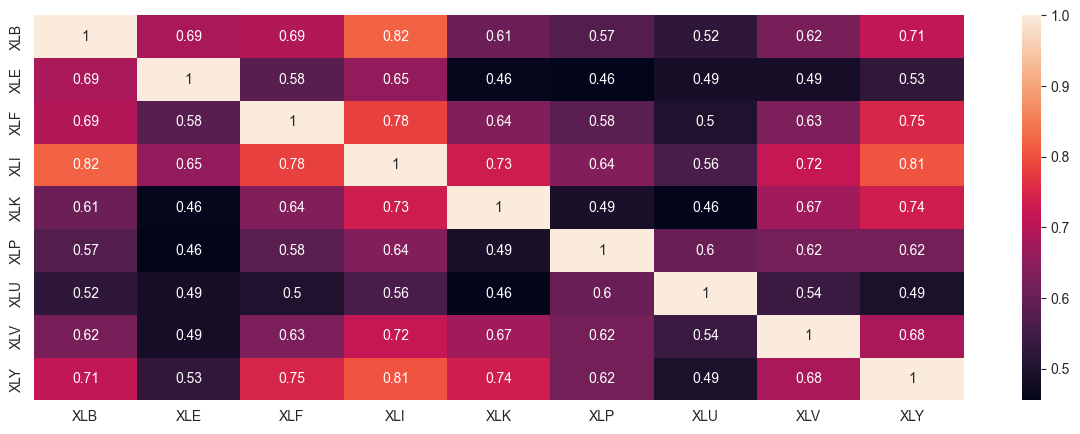

In [34]:
lookbacks = np.arange(4, 252+1, 1)

sns.heatmap(normalizedDataframe.corr(), annot=True)
plt.show()

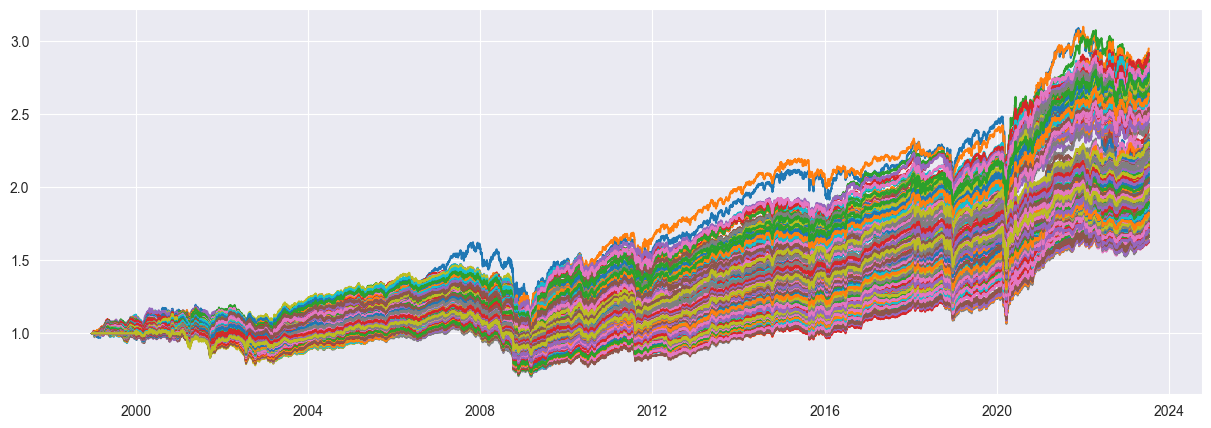

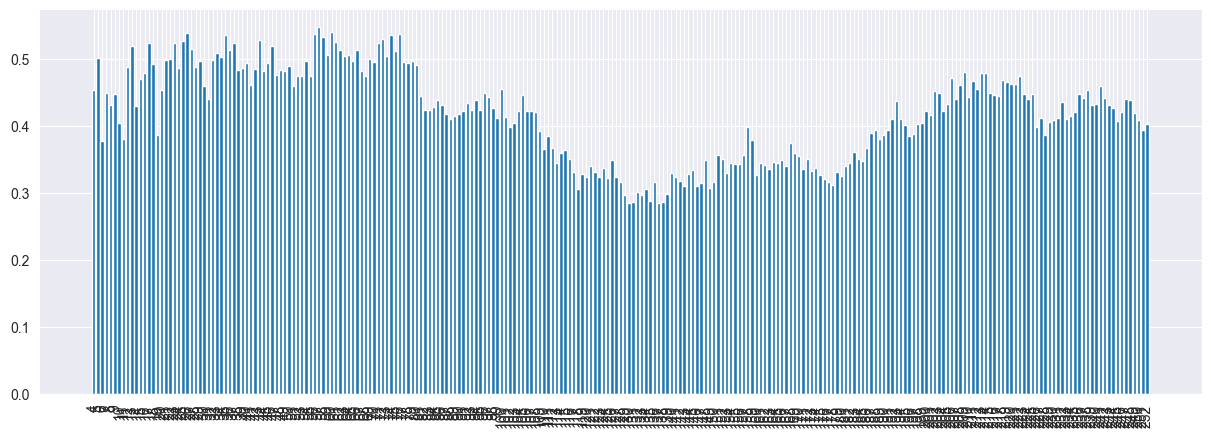

In [35]:
def backtest(dataframe, lookbacks, sharpes):
    for lookback in lookbacks:
        signal = None

        weights = np.ones(len(dataframe.columns)) / len(dataframe.columns)

        signal = dataframe.rolling(lookback).kurt()
        signal = signal.apply(lambda row: (row - row.mean()) / row.std(), axis=1)
        signal = signal > 0

        weighted_signal = signal.mul(weights)

        portfolio_returns = (weighted_signal.shift() * dataframe).sum(axis=1)

        cumulative_returns = (portfolio_returns + 1).cumprod()
        plt.plot(cumulative_returns)

        # print('Sharpe', (portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)))
        sharpes.append((portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)))

    # plt.legend(lookbacks)
    plt.show()

    plt.bar(lookbacks, sharpes, tick_label=lookbacks)
    plt.xticks(rotation=90)
    plt.show()

backtest(normalizedDataframe, lookbacks, [])

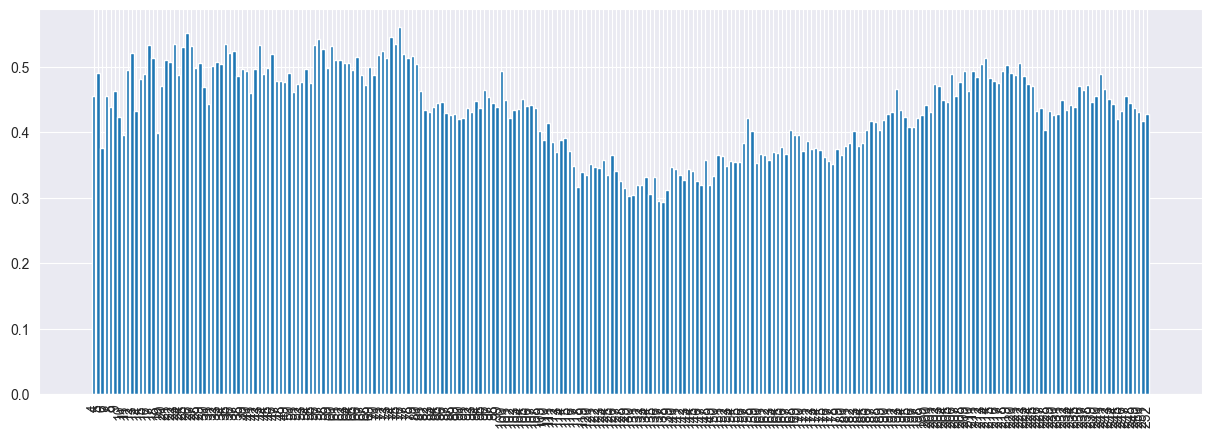

In [36]:
# divide dataframe into 2 and combine the average scores of both sharpes and mdds and plot that
def backtest(dataframe, lookbacks):
    first = dataframe.iloc[:int(len(dataframe)/3)]
    second = dataframe.iloc[int(len(dataframe)/3):int(len(dataframe)/3)*2]
    third = dataframe.iloc[int(len(dataframe)/3)*2:]

    dataframes = [first, second, third]

    sharpes = np.zeros((len(lookbacks), 3))

    for i, dataframe in enumerate(dataframes):
        # print('Fold', i+1)
        for j, lookback in enumerate(lookbacks):

            weights = np.ones(len(dataframe.columns)) / len(dataframe.columns)

            signal = dataframe.rolling(lookback).kurt()
            signal = signal.apply(lambda row: (row - row.mean()) / row.std(), axis=1)
            signal = signal > 0

            weighted_signal = signal.mul(weights)

            portfolio_returns = (weighted_signal.shift() * dataframe).sum(axis=1)
            cumulative_returns = (portfolio_returns + 1).cumprod()
            # plt.plot(cumulative_returns)

            # print(lookback)
            # print('Sharpe', (portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)))
            sharpes[j, i] = (portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252))

    sharpes = sharpes.mean(axis=1)

    plt.bar(lookbacks, sharpes, tick_label=lookbacks)
    plt.xticks(rotation=90)
    plt.show()

    return np.argmax(sharpes)

highest_sharpe = backtest(normalizedDataframe, lookbacks)

76
Sharpe 0.5371160392292454


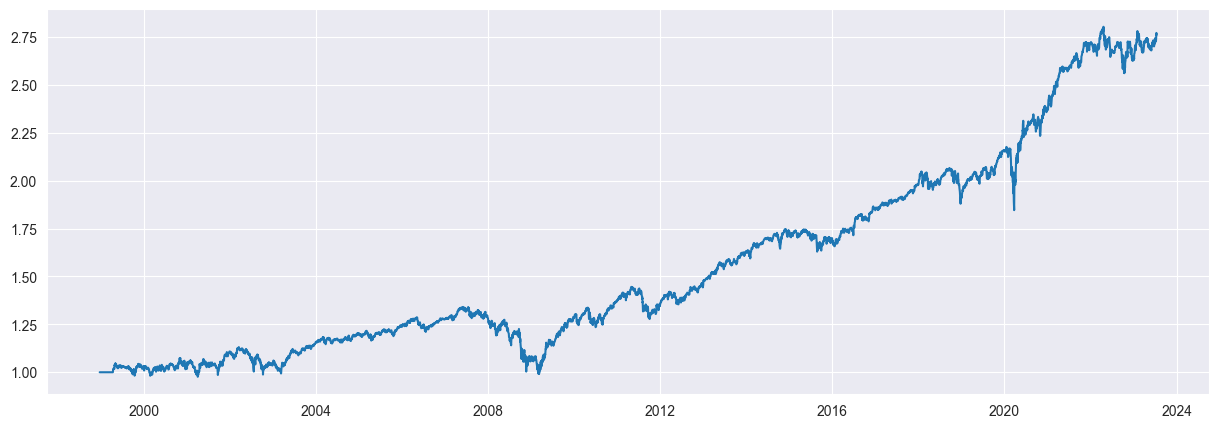

Assets contributing most to strategy (highest to lowest): 
XLY    0.253520
XLE    0.180513
XLK    0.163510
XLF    0.151885
XLV    0.136979
XLU    0.101139
XLP    0.071200
XLI    0.054648
XLB   -0.011893
dtype: float64


In [37]:
def backtest(dataframe, highest_sharpe):
    lookback = lookbacks[highest_sharpe]

    print(lookback)

    weights = np.ones(len(dataframe.columns)) / len(dataframe.columns)

    signal = dataframe.rolling(lookback).kurt()
    signal = signal.apply(lambda row: (row - row.mean()) / row.std(), axis=1)
    signal = signal > 0

    weighted_signal = signal.mul(weights)

    portfolio_returns = (weighted_signal.shift() * dataframe).sum(axis=1)
    cumulative_returns = (portfolio_returns + 1).cumprod()
    plt.plot(cumulative_returns)

    print('Sharpe', (portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)))

    plt.show()

    column_returns = (weighted_signal.shift() * dataframe).sum()
    print('Assets contributing most to strategy (highest to lowest): ')
    print(column_returns.sort_values(ascending=False))

backtest(normalizedDataframe, highest_sharpe)

# Notes

The best lookback parameter for this cross sectional positive kurtosis strategy is 76 days and the highest returning sector is the consumer discretionary sector.